## **Pendahuluan**

Pada praktikum ini, kita akan membangun sebuah model klasifikasi gambar menggunakan TensorFlow dan Keras.
Model ini akan digunakan untuk mengklasifikasikan gambar menjadi tiga kategori: **Rock, Paper, dan Scissors**.

Agar proses pelatihan menjadi lebih efisien dan cepat, kita akan memanfaatkan teknik **Transfer Learning** dengan menggunakan model pre-trained **MobileNetV2** sebagai feature extractor.

### **Dataset**

Dataset yang digunakan dalam praktikum ini berasal dari Kaggle, dan dapat diunduh melalui tautan berikut:

🔗 [Rock-Paper-Scissors Dataset – Kaggle](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors)

Setelah mendownload dataset dan mengekstraknya, **praktikan diwajibkan** untuk menyusun struktur folder dataset menjadi seperti berikut:

<pre>
dataset/
    rock/
    paper/
    scissor/
</pre>



### **Load Dataset**
---

Kode di bawah ini digunakan untuk memuat dataset citra dari struktur folder yang telah disiapkan sebelumnya.

Praktikan diminta untuk:

- Menentukan **ukuran gambar** (`img_size`) sesuai dengan model yang akan digunakan (misalnya 224x224 untuk MobileNetV2).
- Mengatur **ukuran batch** (`batch_size`) sesuai kapasitas RAM/VRAM masing-masing.
- Mengisi nilai **`seed`** untuk memastikan bahwa hasil pembagian data bisa direproduksi kembali dengan urutan yang sama setiap kali dijalankan.

Dataset akan dibagi menjadi tiga bagian:
- **Training set**: 70%
- **Validation set**: 15%
- **Testing set**: 15%

Proses pemuatan data dilakukan dengan menggunakan fungsi bawaan TensorFlow, yaitu `image_dataset_from_directory()`, yang akan secara otomatis membaca gambar berdasarkan nama subfoldernya sebagai label.

> **Catatan:**
> Praktikan diperbolehkan untuk **menyesuaikan sendiri persentase pembagian data** (misalnya 80% train, 10% val, 10% test) selama proporsinya tetap konsisten dan masuk akal.  
> Praktikan juga dapat mengubah **ukuran gambar (`img_size`)** jika ingin menggunakan arsitektur model yang berbeda, serta **mengganti nilai `seed`** untuk mencoba hasil pembagian data yang berbeda.

Setelah training set dan validation+test set dimuat, validation dan test akan dipisahkan secara manual berdasarkan fraksi yang telah ditentukan.


In [2]:

import tensorflow as tf
from tensorflow.keras import layers
import os

# === PARAMETER YANG HARUS DITENTUKAN PRAKTIKAN ===
dataset_dir = "dataset"          # folder utama dataset
img_size    = (224, 224)         # ukuran gambar (isi sendiri)
batch_size  = 16                 # ukuran batch
seed        = 42                 # random seed untuk reproducibility

# Dapatkan daftar kelas dari folder
classes = sorted(os.listdir(dataset_dir))

# === ATURAN SPLIT DATA ===
train_frac = 0.70
val_frac   = 0.15
test_frac  = 0.15
vt_frac    = val_frac + test_frac   # val + test (untuk split manual nanti)

# === MEMUAT TRAIN DATASET ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",        # gunakan one-hot encoding
)

# === MEMUAT VALIDATION + TEST DATASET (gabungan) ===
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
)

# === SPLIT VAL DAN TEST SECARA MANUAL ===
vt_batches  = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = int(vt_batches * (val_frac / vt_frac))   # hitung proporsi val dalam val+test

val_ds  = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)


Found 2188 files belonging to 3 classes.
Using 1532 files for training.
Found 2188 files belonging to 3 classes.
Using 656 files for validation.


### **Preprocessing dan Augmentasi Data**
---

Sebelum gambar dapat digunakan untuk melatih model, dataset perlu melalui proses **preprocessing** terlebih dahulu. Preprocessing ini bertujuan untuk memastikan bahwa semua input gambar berada dalam skala nilai yang konsisten dan sesuai dengan ekspektasi dari model.

Pada praktikum ini, preprocessing dilakukan melalui dua tahap:

1. **Normalisasi**:  
   Setiap pixel gambar yang awalnya berada pada rentang nilai **[0, 255]** diubah ke rentang **[0, 1]** dengan menggunakan layer `Rescaling(1./255)`.

2. **Augmentasi** (opsional):  
   Untuk meningkatkan variasi data dan mengurangi overfitting, dilakukan augmentasi pada **data training saja**. Augmentasi dilakukan melalui transformasi berikut:
   - `RandomFlip("horizontal")`: membalik gambar secara horizontal.
   - `RandomRotation(0.1)`: memutar gambar secara acak hingga 10%.
   - `RandomZoom(0.1, 0.1)`: melakukan zoom in/out hingga 10%.
   - `RandomContrast(0.1)`: mengubah kontras gambar secara acak hingga ±10%.

Semua preprocessing dan augmentasi dilakukan melalui fungsi `prep()`.  
Fungsi ini menerima parameter `augment` untuk menentukan apakah augmentasi akan diterapkan atau tidak.  
- Jika `augment=True`, maka data akan dinormalisasi lalu diaugmentasi.  
- Jika `augment=False`, maka hanya normalisasi yang dilakukan (untuk validation dan test set).

Setelah diproses, setiap dataset akan di-cache dan di-prefetch menggunakan `AUTOTUNE` untuk mengoptimalkan performa saat training.

> **Catatan untuk praktikan:**  
> Praktikan dapat menyesuaikan jenis dan tingkat augmentasi pada `aug_layer` untuk melihat pengaruhnya terhadap performa model. Namun, augmentasi **hanya boleh diterapkan pada training set**.


In [3]:
from tensorflow.keras import layers

# praktikan diminta melengkapi isi preprocessing dan augmentasi
norm_layer = tf.keras.Sequential([
    layers.Rescaling(1./255),  # lengkapi: normalisasi ke [0,1]
])

aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),    # flip kiri-kanan
    layers.RandomRotation(0.1),         # rotasi ±10%
    layers.RandomZoom(0.1, 0.1),        # zoom in/out sampai 10%
    layers.RandomContrast(0.1),         # kontras +-10%
])

# fungsi untuk mempersiapkan dataset
def prep(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (aug_layer(norm_layer(x), training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (norm_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    return ds.cache().prefetch(tf.data.AUTOTUNE)

# Praktikan diminta menentukan kapan augmentasi diaktifkan
train_ds = prep(train_ds, augment=True)
val_ds   = prep(val_ds,   augment=False)
test_ds  = prep(test_ds,  augment=False)


### **Build Model dan Training**
---

Pada tahap ini, kita akan membangun arsitektur model menggunakan teknik **Transfer Learning** dengan memanfaatkan **MobileNetV2** sebagai feature extractor.

Praktikan diminta untuk:

- **Melengkapi input layer** (`inputs`) dengan ukuran shape gambar yang sesuai.
- **Melengkapi output layer** (`outputs`) dengan jumlah neuron yang sama dengan jumlah kelas target (jumlah kategori pada dataset).

Bagian head klasifikasi model disusun dengan struktur:

- **GlobalAveragePooling2D**: Mengubah output feature map menjadi satu vektor rata-rata per channel.
- **Dropout**: Teknik regularisasi untuk mengurangi overfitting.
- **Dense (Softmax)**: Layer output yang mengklasifikasikan input ke dalam salah satu kelas.

---

### **Training Model**

Sebelum memulai proses pelatihan, kita juga telah mendefinisikan dua buah callbacks:

- `EarlyStopping`: Untuk menghentikan pelatihan jika validation loss tidak membaik setelah sejumlah epoch tertentu.
- `ModelCheckpoint`: Untuk menyimpan model terbaik berdasarkan validation loss.

Praktikan diminta untuk:

- **Melengkapi list callbacks** di fungsi `model.fit()`, dengan menambahkan kedua callbacks yang telah dibuat sebelumnya (`early_stopping` dan `model_checkpoint`).
- Menjalankan training selama **50 epoch** atau hingga proses berhenti otomatis karena `EarlyStopping`.

> **Catatan:**  
> Dengan menggunakan callbacks, kita dapat menghindari overfitting dan memastikan model terbaik tersimpan otomatis.



In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained base
base_model = MobileNetV2(
    input_shape=(*img_size, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# Tambahkan head klasifikasi baru
# Praktikan diminta melengkapi bagian input dan output di bawah ini
# Lengkapi bagian yang kosong dengan menyusun arsitektur head klasifikasi
inputs = tf.keras.Input(shape=(*img_size, 3))    # Tentukan input shape
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation="softmax")(x)  # Tentukan jumlah output classes
model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer  = "adam",
    loss       = "categorical_crossentropy",
    metrics    = ["accuracy"]
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor    = "val_loss",
    patience   = 3,
    restore_best_weights=True
)
model_checkpoint = callbacks.ModelCheckpoint(
    "best_transfer.h5",
    monitor="val_loss",
    save_best_only=True
)

# Training model
# Praktikan diminta melengkapi callbacks yang digunakan
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]    # Lengkapi dengan callbacks yang telah dibuat
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6935 - loss: 0.7072

96/96 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - accuracy: 0.6950 - loss: 0.7042 - val_accuracy: 0.9875 - val_loss: 0.1064
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9694 - loss: 0.1182

96/96 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9695 - loss: 0.1180 - val_accuracy: 0.9875 - val_loss: 0.0587
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9830 - loss: 0.0714

96/96 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9831 - loss: 0.0714 - val_accuracy: 0.9906 - val_loss: 0.0387
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9895 - loss: 0.0474

96/96 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9895 - loss: 0.0474 - val_accuracy: 0.9906 - val_loss: 0.0322
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9863 - loss: 0.0479

96/96 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9864 - loss: 0.0479 - val_accuracy: 0.9937 - val_loss: 0.0267
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9939 - loss: 0.0301

96/96 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9939 - loss: 0.0300 - val_accuracy: 0.9906 - val_loss: 0.0223
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9983 - loss: 0.0221

96/96 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9983 - loss: 0.0221 - val_accuracy: 0.9937 - val_loss: 0.0210
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9957 - loss: 0.0212

96/96 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9957 - loss: 0.0212 - val_accuracy: 0.9937 - val_loss: 0.0202
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0176

96/96 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 0.9937 - val_loss: 0.0194
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9982 - loss: 0.0157

96/96 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.9982 - loss: 0.0157 - val_accuracy: 0.9937 - val_loss: 0.0192
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9995 - loss: 0.0138

96/96 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.9995 - loss: 0.0138 - val_accuracy: 0.9937 - val_loss: 0.0162
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.9993 - loss: 0.0124 - val_accuracy: 0.9937 - val_loss: 0.0175
Epoch 13/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0106

96/96 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.9969 - val_loss: 0.0151
Epoch 14/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.9981 - loss: 0.0118 - val_accuracy: 0.9969 - val_loss: 0.0155
Epoch 15/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9999 - loss: 0.0090

96/96 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.9999 - loss: 0.0090 - val_accuracy: 0.9969 - val_loss: 0.0148
Epoch 16/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9996 - loss: 0.0103

96/96 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.9996 - loss: 0.0103 - val_accuracy: 0.9969 - val_loss: 0.0141
Epoch 17/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0075

96/96 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9937 - val_loss: 0.0141
Epoch 18/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0065

96/96 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.9937 - val_loss: 0.0129
Epoch 19/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9996 - loss: 0.0075

96/96 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.9996 - loss: 0.0075 - val_accuracy: 0.9937 - val_loss: 0.0126
Epoch 20/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0069

96/96 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9937 - val_loss: 0.0120
Epoch 21/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9982 - loss: 0.0092

96/96 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.9982 - loss: 0.0092 - val_accuracy: 0.9937 - val_loss: 0.0112
Epoch 22/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9969 - val_loss: 0.0131
Epoch 23/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9996 - loss: 0.0047 - val_accuracy: 0.9937 - val_loss: 0.0119
Epoch 24/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9994 - loss: 0.0045

96/96 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.9994 - loss: 0.0046 - val_accuracy: 0.9937 - val_loss: 0.0110
Epoch 25/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9937 - val_loss: 0.0121
Epoch 26/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9999 - loss: 0.0035 - val_accuracy: 0.9969 - val_loss: 0.0118
Epoch 27/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0054

96/96 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9969 - val_loss: 0.0108
Epoch 28/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 0.9993 - loss: 0.0052 - val_accuracy: 0.9969 - val_loss: 0.0113
Epoch 29/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0043

96/96 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9937 - val_loss: 0.0103
Epoch 30/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 436s 5s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9969 - val_loss: 0.0115
Epoch 31/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 396s 4s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9937 - val_loss: 0.0113
Epoch 32/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9969 - val_loss: 0.0110


### **Evaluasi Model**
---

Setelah model selesai dilatih, langkah berikutnya adalah mengevaluasi performanya pada **test set**.

Evaluasi dilakukan menggunakan dua pendekatan utama:

1. **Classification Report**  
   Menampilkan metrik klasifikasi seperti:
   - **Precision**: Seberapa akurat model saat membuat prediksi positif.
   - **Recall**: Seberapa baik model menangkap semua sampel positif.
   - **F1-Score**: Harmoni antara precision dan recall.
   - **Accuracy**: Persentase prediksi yang benar dari semua prediksi.

2. **Confusion Matrix**  
   Menunjukkan jumlah prediksi benar dan salah untuk masing-masing kelas, dalam bentuk tabel.  
   Dengan confusion matrix, kita bisa melihat pola kesalahan model (misal, apakah model sering salah membedakan "rock" dengan "paper", dll).

---

#### Langkah-langkah yang dilakukan pada kode:

- Menggunakan model untuk melakukan prediksi pada seluruh test dataset.
- Membandingkan hasil prediksi dengan label asli.
- Menampilkan classification report menggunakan `classification_report` dari scikit-learn.
- Menghitung dan memvisualisasikan confusion matrix menggunakan `ConfusionMatrixDisplay`.

> **Catatan untuk praktikan:**  
> Perhatikan nilai **precision**, **recall**, dan **f1-score** dari masing-masing kelas.  
> Jika terdapat ketidakseimbangan performa antar kelas, analisis kemungkinan penyebabnya (misalnya karena jumlah data tidak seimbang, kesamaan visual antar kelas, dsb).


21/21 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step
=== Classification Report ===
              precision    recall  f1-score   support

       paper     0.9787    0.9892    0.9840        93
        rock     0.9915    0.9915    0.9915       117
    scissors     0.9920    0.9841    0.9880       126

    accuracy                         0.9881       336
   macro avg     0.9874    0.9883    0.9878       336
weighted avg     0.9881    0.9881    0.9881       336



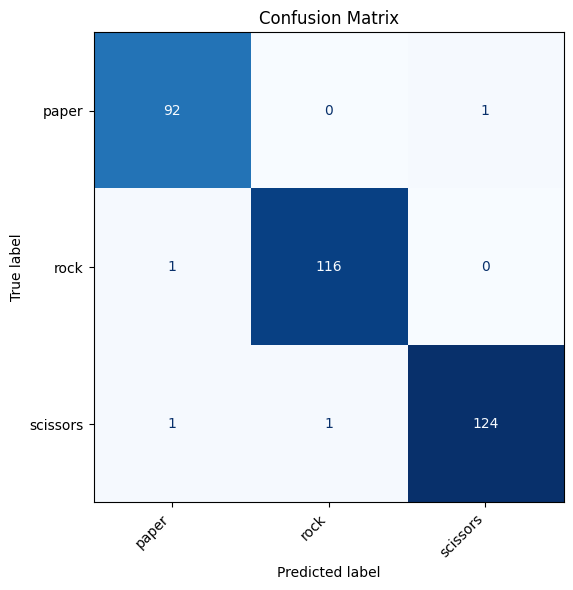

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# dapatkan prediksi probabilitas dan label dari test set
y_pred_probs = model.predict(test_ds)               # shape = (N, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)             # ambil indeks prediksi tertinggi (shape: (N,))

# ekstrak label asli dari test_ds
#    Karena test_ds bertipe (x_batch, y_batch) dengan label one-hot, kita ambil argmax dari y_batch
y_true = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in test_ds
], axis=0)

# tampilkan classification report
print("=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
))

# hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Setelah proses pelatihan selesai, model yang telah dilatih akan secara otomatis disimpan oleh callback `ModelCheckpoint` ke dalam file `.h5`.

Model ini dapat langsung digunakan dalam pengembangan aplikasi backend yang menggunakan **FastAPI** atau frontend berbasis **Streamlit**, untuk membuat aplikasi klasifikasi gambar.